# Fine-tuning EfficientNet B0 for Food Classification into Fresh/Rotten

The EfficientNet-B0 model is finetuned on a dataset of 4800 images with fresh and rotten images of apples, oranges, banana, cucumber, okra, capsicum, potato, and tomato. Each class has 600 images covering diverse position and deterioration level of the food item.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.17.1
3.8.0


In [3]:
!pip uninstall tensorflow -y  # Uninstall current version
!pip uninstall keras -y       # Optional: Only if a standalone Keras is installed

# Install the specific version you want (e.g., TensorFlow 2.15.0)
!pip install tensorflow==2.17.1

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 97.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.17.1 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0

# Create 70:15:15 Split Dataset

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(base_dir, output_dir, split_ratios=(0.7, 0.15, 0.15)):
    # Ensure the output directories exist
    for split in ['train', 'val', 'test']:
        for label in ['fresh', 'rotten']:
            os.makedirs(os.path.join(output_dir, split, label), exist_ok=True)

    # Loop through each main category (fresh/rotten)
    for label in ['fresh', 'rotten']:
        label_dir = os.path.join(base_dir, label)
        food_types = os.listdir(label_dir)

        # Loop through each subfolder (food type)
        for food_type in food_types:
            food_dir = os.path.join(label_dir, food_type)
            images = os.listdir(food_dir)

            # Split into train, val, and test
            train_images, temp_images = train_test_split(images, test_size=(1 - split_ratios[0]), random_state=42)
            val_images, test_images = train_test_split(temp_images, test_size=split_ratios[2] / (split_ratios[1] + split_ratios[2]), random_state=42)

            # Move the files to their respective directories
            for split, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
                split_dir = os.path.join(output_dir, split, label, food_type)
                os.makedirs(split_dir, exist_ok=True)
                for img in split_images:
                    src = os.path.join(food_dir, img)
                    dst = os.path.join(split_dir, img)
                    shutil.copy(src, dst)

# Paths
base_dataset_dir = "/content/drive/MyDrive/FeedBridge/food_dataset"  # The folder containing 'fresh' and 'rotten'
output_dataset_dir = "/content/drive/MyDrive/FeedBridge/split_dataset"

# Perform the split
split_dataset(base_dataset_dir, output_dataset_dir)

# Prepare Data for model training and evaluation

In [ ]:
# Paths
base_dir = '/content/drive/MyDrive/FeedBridge/split_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

IMG_SIZE = 224
BATCH_SIZE = 128

In [ ]:
# Data augmentation layers
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

# Function to apply data augmentation
def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

# Preprocessing functions
def input_preprocess_train(image, label):
    # Normalize to [0, 1] range and apply augmentations
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = img_augmentation(image)
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label

def input_preprocess_test(image, label):
    # Normalize to [0, 1] range
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label

# Load datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# Class names and number of classes
class_names = train_dataset.class_names  # ['fresh', 'rotten']
num_classes = len(class_names)  # Should be 2 (binary classification)

# Apply preprocessing
train_dataset = train_dataset.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

# Optimize for performance
train_dataset = train_dataset.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 3344 files belonging to 2 classes.
Found 720 files belonging to 2 classes.
Found 736 files belonging to 2 classes.


# Define model architecture with custom layers

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    base_model.trainable = False

    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5, name="top_dropout")(x)

    outputs = layers.Dense(
        num_classes,
        activation="softmax",
        name="pred",
        kernel_regularizer=regularizers.l2(0.001)  # L2 regularization
    )(x)

    model = models.Model(inputs, outputs, name="EfficientNet")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), #reduced 2 to 3
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

model = build_model(num_classes)

16705208/16705208 [==============================] - 0s 0us/step


# Train and save the trained model (transfer learning)

In [ ]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Epoch 1/15
27/27 [==============================] - 425s 15s/step - loss: 0.6951 - accuracy: 0.7210 - val_loss: 0.3800 - val_accuracy: 0.8625
Epoch 2/15
27/27 [==============================] - 411s 15s/step - loss: 0.3754 - accuracy: 0.8502 - val_loss: 0.3121 - val_accuracy: 0.9042
Epoch 3/15
27/27 [==============================] - 413s 15s/step - loss: 0.3103 - accuracy: 0.8813 - val_loss: 0.2816 - val_accuracy: 0.9139
Epoch 4/15
27/27 [==============================] - 411s 15s/step - loss: 0.2799 - accuracy: 0.8941 - val_loss: 0.2540 - val_accuracy: 0.9250
Epoch 5/15
27/27 [==============================] - 411s 15s/step - loss: 0.2470 - accuracy: 0.9070 - val_loss: 0.2323 - val_accuracy: 0.9319
Epoch 6/15
27/27 [==============================] - 411s 15s/step - loss: 0.2300 - accuracy: 0.9115 - val_loss: 0.2111 - val_accuracy: 0.9389
Epoch 7/15
27/27 [==============================] - 410s 15s/step - loss: 0.2340 - accuracy: 0.9070 - val_loss: 0.2025 - val_accuracy: 0.9389
Epoch 

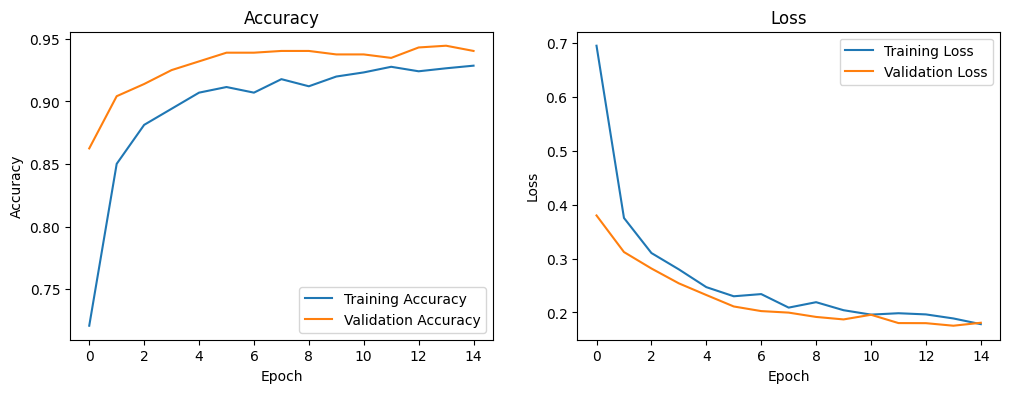

6/6 [==============================] - 75s 12s/step - loss: 0.1752 - accuracy: 0.9361
Test Accuracy: 0.9361
Test Loss: 0.1752


In [ ]:
epochs = 15

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)

plot_history(history)

model_dir = '/content/drive/MyDrive/FeedBridge'
model_path = os.path.join(model_dir, 'saved_model.keras')
model.save(model_path)
model.save_weights('model_weights.weights.h5')


test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Fine-tune the trained model by unfreezing model weights for few layers

In [ ]:
#continue from prev. checkpoint weights

from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/FeedBridge/saved_model.keras'
model = load_model(model_path)

Epoch 1/10
27/27 [==============================] - 949s 19s/step - loss: 0.2059 - accuracy: 0.9285 - val_loss: 0.1713 - val_accuracy: 0.9542
Epoch 2/10
27/27 [==============================] - 415s 13s/step - loss: 0.1024 - accuracy: 0.9632 - val_loss: 0.1825 - val_accuracy: 0.9528
Epoch 3/10
27/27 [==============================] - 431s 14s/step - loss: 0.0963 - accuracy: 0.9626 - val_loss: 0.1198 - val_accuracy: 0.9681
Epoch 4/10
27/27 [==============================] - 428s 14s/step - loss: 0.0753 - accuracy: 0.9731 - val_loss: 0.1480 - val_accuracy: 0.9611
Epoch 5/10
27/27 [==============================] - 430s 14s/step - loss: 0.0597 - accuracy: 0.9815 - val_loss: 0.1088 - val_accuracy: 0.9750
Epoch 6/10
27/27 [==============================] - 433s 14s/step - loss: 0.0529 - accuracy: 0.9788 - val_loss: 0.1257 - val_accuracy: 0.9653
Epoch 7/10
27/27 [==============================] - 433s 14s/step - loss: 0.0666 - accuracy: 0.9770 - val_loss: 0.1100 - val_accuracy: 0.9736
Epoch 

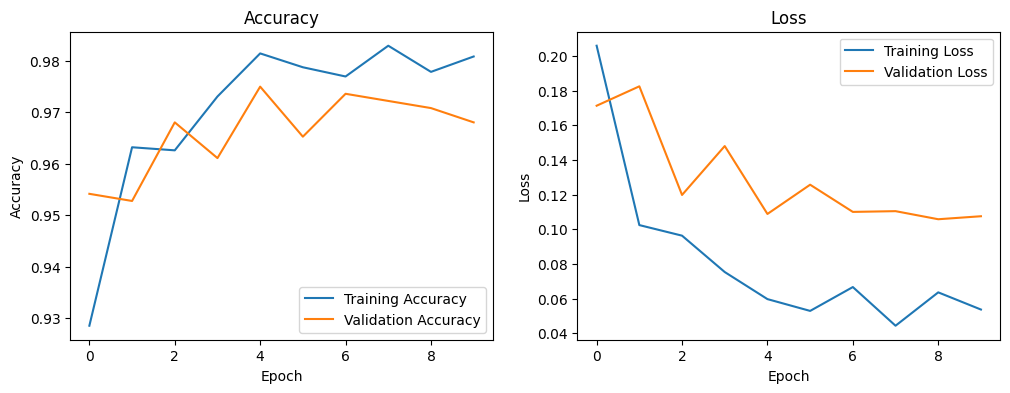

6/6 [==============================] - 151s 9s/step - loss: 0.1627 - accuracy: 0.9592
Test Accuracy: 0.9592
Test Loss: 0.1627


In [ ]:
def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model)

epochs = 10
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

plot_history(history)

model_dir = '/content/drive/MyDrive/FeedBridge'
model_path = os.path.join(model_dir, 'saved_model_ft.keras')
model.save(model_path)
model.save_weights('model_weights_ft.weights.h5')

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Model performance metrics on test dataset

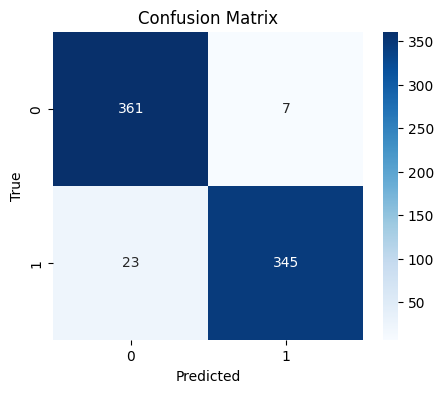

Classification Report:

              precision    recall  f1-score   support

       Fresh       0.94      0.98      0.96       368
      Rotten       0.98      0.94      0.96       368

    accuracy                           0.96       736
   macro avg       0.96      0.96      0.96       736
weighted avg       0.96      0.96      0.96       736



In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for images, labels in test_dataset:
    y_pred_prob = model(images, training=False)
    y_pred_batch = tf.argmax(y_pred_prob, axis=1)
    y_true_batch = tf.argmax(labels, axis=1)

    y_true.extend(y_true_batch.numpy())
    y_pred.extend(y_pred_batch.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_true, y_pred, target_names=['Fresh', 'Rotten'])
print("Classification Report:\n")
print(class_report)

In [ ]:
# Overall metrics
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()
accuracy_metric = tf.keras.metrics.Accuracy()

for images, labels in test_dataset:
    y_pred_prob = model(images, training=False)
    y_pred = tf.argmax(y_pred_prob, axis=1)
    y_true = tf.argmax(labels, axis=1)

    precision_metric.update_state(y_true, y_pred)
    recall_metric.update_state(y_true, y_pred)
    accuracy_metric.update_state(y_true, y_pred)

precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()

f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.9801
Recall: 0.9375
F1-score: 0.9583
Accuracy: 0.9592


# Model Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


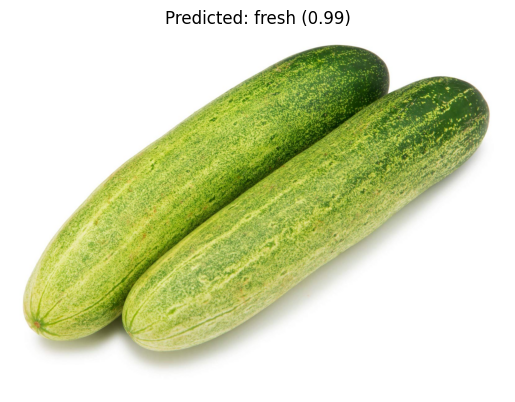

Predicted class index: 0
Predicted label: fresh
Confidence score: 0.9908
Inference time: 3.6969 seconds


In [7]:
# Loads saved weights to perform inference

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import time  # Import the time module
import matplotlib.pyplot as plt


IMG_SIZE = 224
num_classes = 2

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    base_model.trainable = False

    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5, name="top_dropout")(x)
    outputs = layers.Dense(
        num_classes,
        activation="softmax",
        name="pred",
        kernel_regularizer=regularizers.l2(0.001)
    )(x)

    model = models.Model(inputs, outputs, name="EfficientNet_with_custom_layers")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

model = build_model(num_classes)

# Load the saved weights
weights_path = '/content/drive/MyDrive/FeedBridge/saved_model.weights.h5'
model.load_weights(weights_path)

def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Image to perform inference
img_path = '/content/drive/MyDrive/FeedBridge/test_images/fcucumber1.jpg'

# Start time measurement
start_time = time.time()

# Preprocess image
img_array = preprocess_image(img_path)

# Make predictions
predictions = model.predict(img_array)

# End time measurement
end_time = time.time()

# Calculate time taken for inference
inference_time = end_time - start_time
predicted_class = np.argmax(predictions, axis=1)
confidence_scores = predictions[0]

class_labels = ['fresh', 'rotten']
predicted_label = class_labels[predicted_class[0]]
confidence_score = confidence_scores[predicted_class[0]]

# Display the image
img = plt.imread(img_path)
plt.imshow(img)
plt.axis('off')  # Hide axes for better visualization
plt.title(f"Predicted: {predicted_label} ({confidence_score:.2f})")
plt.show()

print(f"Predicted class index: {predicted_class[0]}")
print(f"Predicted label: {predicted_label}")
print(f"Confidence score: {confidence_score:.4f}")
print(f"Inference time: {inference_time:.4f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


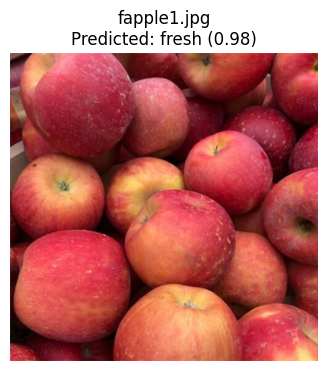

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


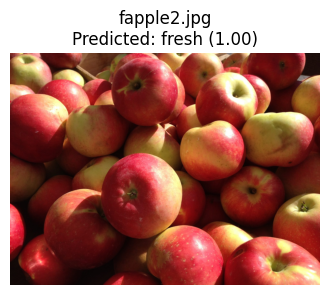

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


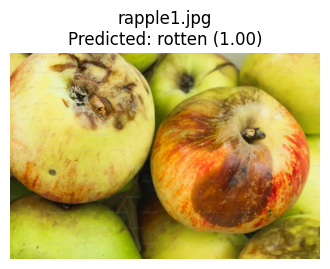

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


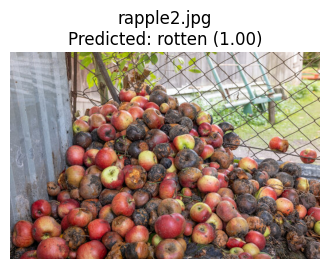

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


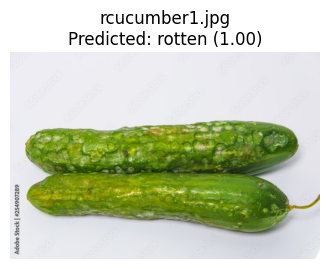

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


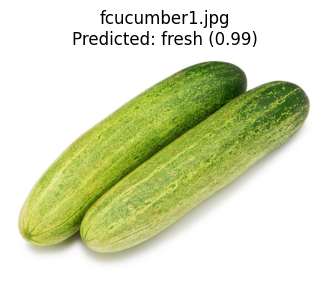

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


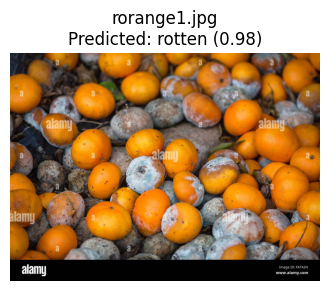

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


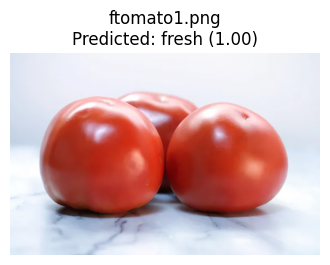

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


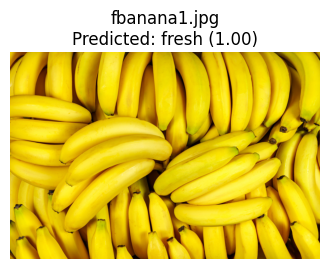

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


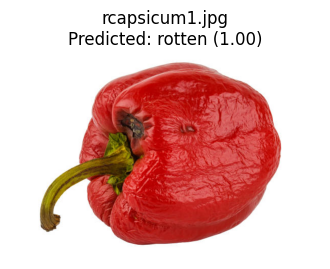

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


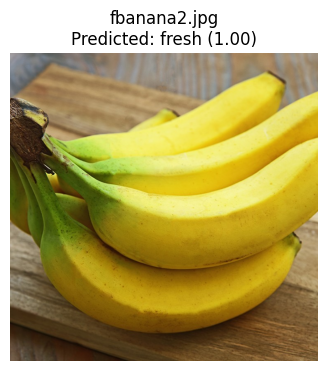

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


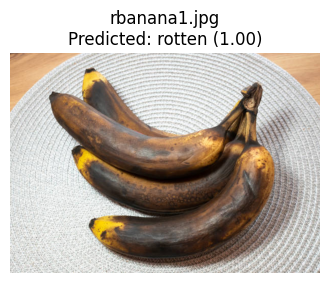

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


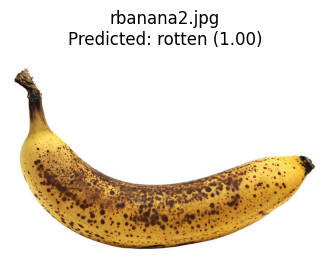

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


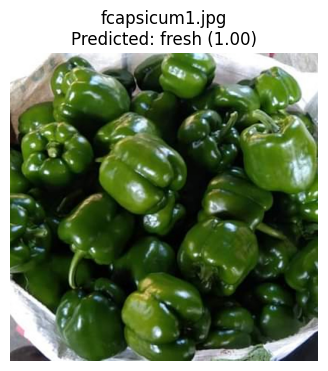

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


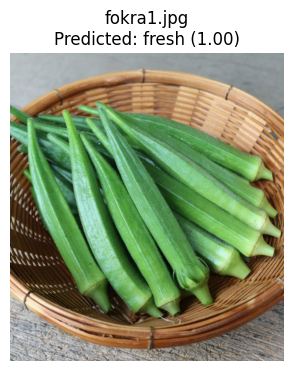

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


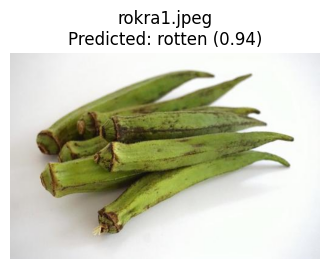

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


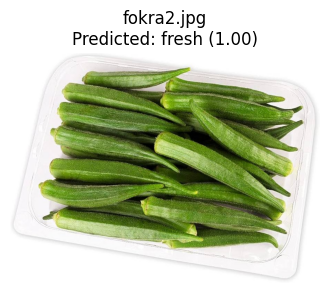

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


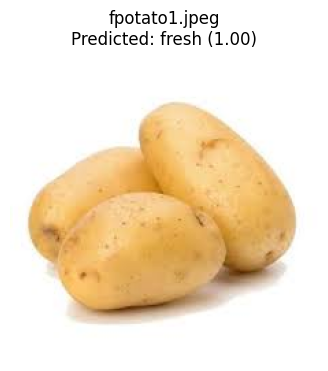

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


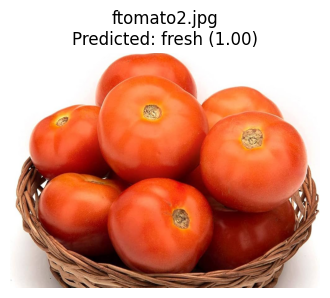

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


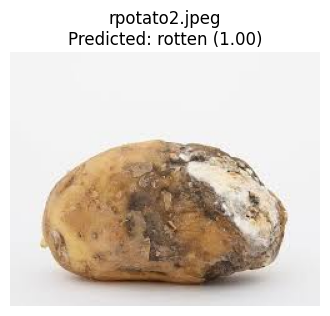

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


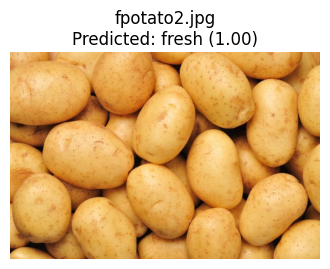

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


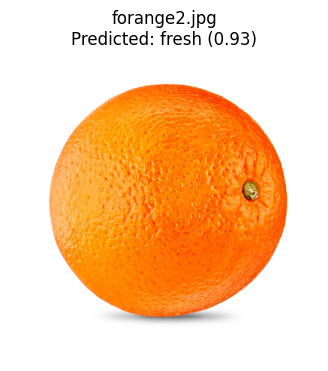

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


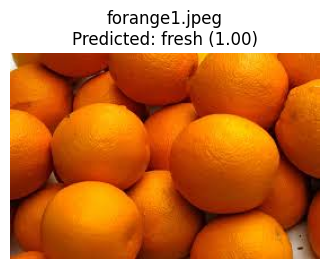

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


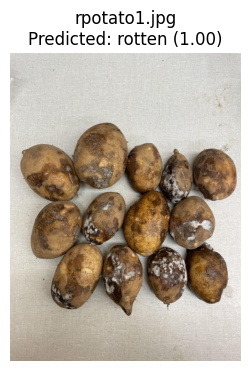

In [10]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 224
num_classes = 2

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    base_model.trainable = False

    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5, name="top_dropout")(x)
    outputs = layers.Dense(
        num_classes,
        activation="softmax",
        name="pred",
        kernel_regularizer=regularizers.l2(0.001)
    )(x)

    model = models.Model(inputs, outputs, name="EfficientNet_with_custom_layers")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

model = build_model(num_classes)

# Load the saved weights
weights_path = '/content/drive/MyDrive/FeedBridge/saved_model.weights.h5'
model.load_weights(weights_path)

def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Directory containing test images
test_images_folder = "/content/drive/MyDrive/FeedBridge/test_images"

# Get all image file paths
image_files = [f for f in os.listdir(test_images_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Class labels
class_labels = ['fresh', 'rotten']

# Loop through all images in the test_images folder
for img_file in image_files:
    img_path = os.path.join(test_images_folder, img_file)

    # Preprocess image
    img_array = preprocess_image(img_path)

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    confidence_scores = predictions[0]

    predicted_label = class_labels[predicted_class[0]]
    confidence_score = confidence_scores[predicted_class[0]]

    # Display the image
    img = image.load_img(img_path, target_size=(300, 300))  # Resize image for uniformity
    plt.figure(figsize=(4, 4))
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes for better visualization
    plt.title(f"{img_file}\nPredicted: {predicted_label} ({confidence_score:.2f})")
    plt.show()